# Notebook pour répondre aux questions de la partie 3

In stores many decisions are made by managers at the department level.  
In order to help store managers in making mid-term decisions driven by economic data, we want to forecast the turnover for the next 8 weeks at store-department level.

## a. Build an estimator able to predict the turnover of test.csv.gz data.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Preprocessing

In [132]:
df_train = pd.read_csv('../data/train.csv')
df_train['day_id'] = pd.to_datetime(df_train['day_id'], format='%Y-%m-%d')
df_train['year'] = df_train['day_id'].dt.year
df_train['month'] = df_train['day_id'].dt.month
df_train['day'] = df_train['day_id'].dt.day
df_train['week_nb'] = df_train['day_id'].dt.isocalendar().week

In [133]:
df_test = pd.read_csv('../data/test.csv')
df_test['day_id'] = pd.to_datetime(df_test['day_id'], format='%Y-%m-%d')
df_test['year'] = df_test['day_id'].dt.year
df_test['month'] = df_test['day_id'].dt.month
df_test['day'] = df_test['day_id'].dt.day
df_test['week_nb'] = df_test['day_id'].dt.isocalendar().week

In [134]:
# concatenate two string columns and add a dash in between
df_train['store-dep'] = df_train['but_num_business_unit'].astype(str) + '-' + df_train['dpt_num_department'].astype(str)
df_test['store-dep'] = df_test['but_num_business_unit'].astype(str) + '-' + df_test['dpt_num_department'].astype(str)

In [135]:
df_train.sort_values(by=['store-dep','day_id'], inplace=True)

In [136]:
# backfill THE outlier of store-dep 30-88

df_train.loc[231272, 'turnover'] = np.nan
df_train['turnover'] = df_train['turnover'].bfill()

In [137]:

df_train[(df_train['store-dep'] == '30-88') & (df_train['turnover'] > 100000)]

,day_id,but_num_business_unit,dpt_num_department,turnover,year,month,day,week_nb,store-dep


In [138]:
df_train['is_outlier'] = False
for store_dep in df_train['store-dep'].unique():
    # check for outliers in the turnover column
    df_store_dep = df_train[df_train['store-dep'] == store_dep]
    Q1 = df_store_dep['turnover'].quantile(0.25)
    Q3 = df_store_dep['turnover'].quantile(0.75)
    IQR = Q3 - Q1
    df_outliers = df_store_dep[(df_store_dep['turnover'] < (Q1 - 3 * IQR)) | (df_store_dep['turnover'] > (Q3 + 3 * IQR))]
    df_train.loc[df_outliers.index, 'is_outlier'] = True
    


In [139]:
# find outliers based on rolling average of the timeseries
df_train['rolling_mean'] = df_train.groupby('store-dep')['turnover'].transform(lambda x: x.rolling(window=10, center=True).mean())
df_train['rolling_std'] = df_train.groupby('store-dep')['turnover'].transform(lambda x: x.rolling(window=10, center=True).std())
df_train['is_outlier_rolling'] = False
df_train['is_outlier_rolling'] = df_train['is_outlier_rolling'] | (df_train['turnover'] < df_train['rolling_mean'] - 3 * df_train['rolling_std'])
df_train['is_outlier_rolling'] = df_train['is_outlier_rolling'] | (df_train['turnover'] > df_train['rolling_mean'] + 3 * df_train['rolling_std'])


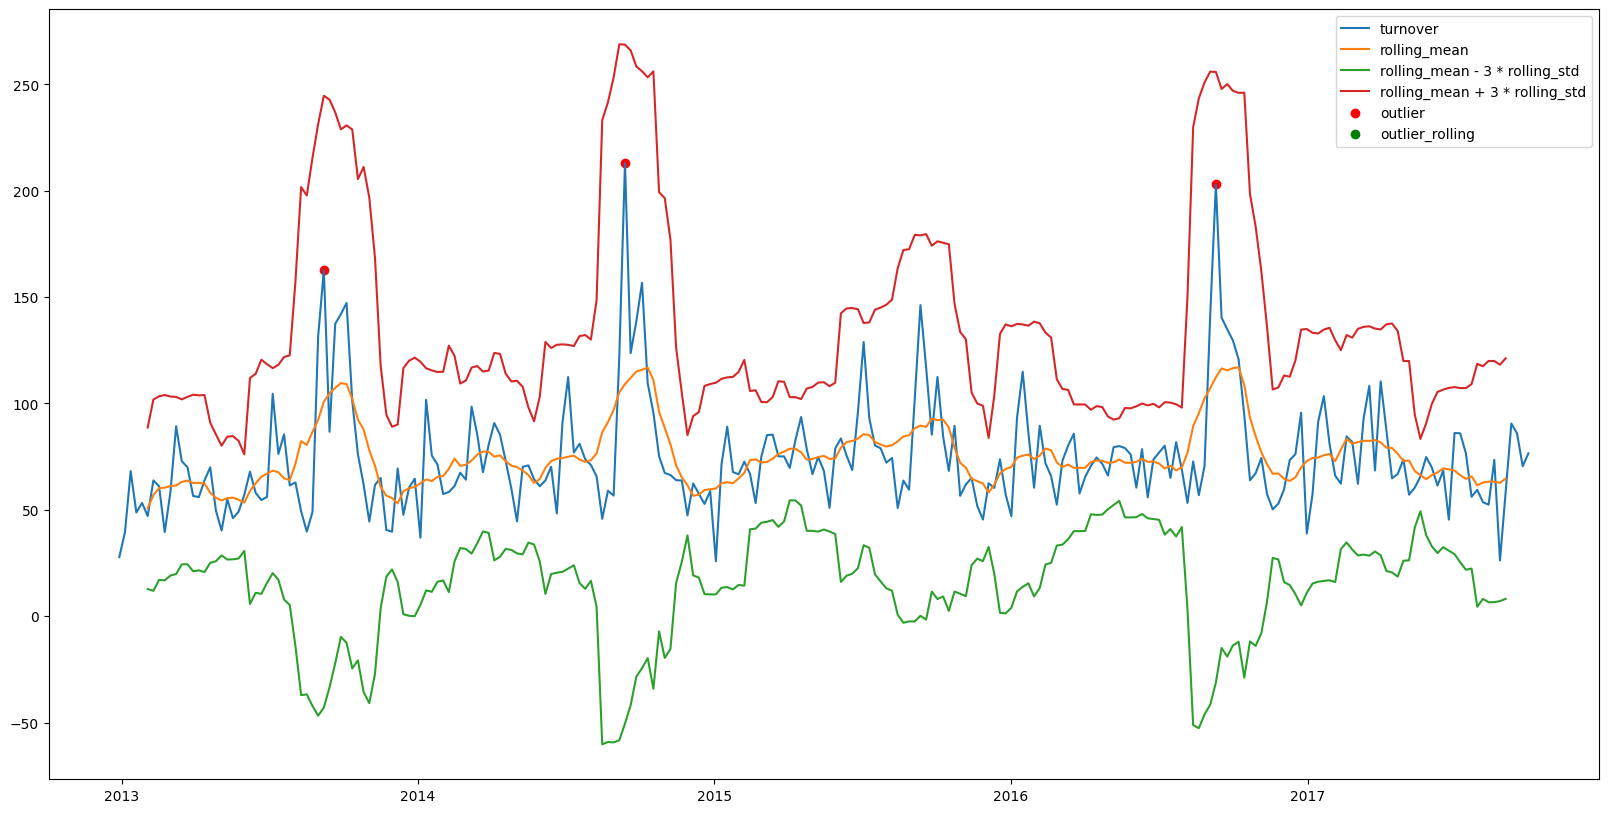

In [140]:
import random

store_dep = random.choice(df_train['store-dep'].unique())
df_store_dep = df_train[df_train['store-dep'] == store_dep]
plt.figure(figsize=(20,10))
plt.plot(df_store_dep['day_id'], df_store_dep['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['rolling_mean'], label='rolling_mean')
plt.plot(df_store_dep['day_id'], df_store_dep['rolling_mean'] - 3 * df_store_dep['rolling_std'], label='rolling_mean - 3 * rolling_std')
plt.plot(df_store_dep['day_id'], df_store_dep['rolling_mean'] + 3 * df_store_dep['rolling_std'], label='rolling_mean + 3 * rolling_std')
plt.scatter(df_store_dep[df_store_dep['is_outlier']].day_id, df_store_dep[df_store_dep['is_outlier']].turnover, color='red', label='outlier')
plt.scatter(df_store_dep[df_store_dep['is_outlier_rolling']].day_id, df_store_dep[df_store_dep['is_outlier_rolling']].turnover, color='green', label='outlier_rolling')
plt.legend()
plt.show()
 

In [141]:
df_train['is_outlier'] = df_train['is_outlier'] & df_train['is_outlier_rolling']

In [142]:
df_train[df_train['is_outlier']]

,day_id,but_num_business_unit,dpt_num_department,turnover,year,month,day,week_nb,store-dep,is_outlier,rolling_mean,rolling_std,is_outlier_rolling


<Axes: xlabel='day_id'>

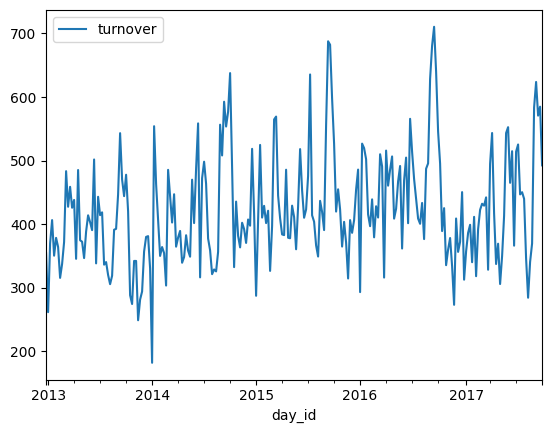

In [143]:
df_train[df_train['store-dep'] == '30-88'].plot(x='day_id', y='turnover')

### Simple baseline

In [148]:
df_train.sort_values(by=['day_id'])[:int(0.7*len(df_train))]

,day_id,but_num_business_unit,dpt_num_department,turnover,year,month,day,week_nb,store-dep,is_outlier,rolling_mean,rolling_std,is_outlier_rolling
277208,2012-12-29,1,117,972.944128,2012,12,29,52,1-117,False,NaN,NaN,False
277090,2012-12-29,156,88,276.808587,2012,12,29,52,156-88,False,NaN,NaN,False
277166,2012-12-29,148,88,259.104659,2012,12,29,52,148-88,False,NaN,NaN,False
277339,2012-12-29,242,127,508.359057,2012,12,29,52,242-127,False,NaN,NaN,False
277704,2012-12-29,113,73,0.730911,2012,12,29,52,113-73,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82920,2016-06-18,156,88,412.654564,2016,6,18,24,156-88,False,500.577652,102.472778,False
83218,2016-06-18,1123,127,344.996241,2016,6,18,24,1123-127,False,333.786170,101.701526,False
83458,2016-06-18,482,88,359.210529,2016,6,18,24,482-88,False,382.467409,201.904607,False
82836,2016-06-18,97,127,3303.106770,2016,6,18,24,97-127,False,3806.573317,1499.176542,False


In [150]:
train_data = df_train.sort_values(by=['day_id'])[:int(0.7*len(df_train))]
valid_data = df_train.sort_values(by=['day_id'])[int(0.7*len(df_train)):]

X_train = train_data[['but_num_business_unit','dpt_num_department', 'year', 'month', 'day', 'week_nb']]
X_valid = valid_data[['but_num_business_unit','dpt_num_department', 'year', 'month', 'day', 'week_nb']]
y_train = train_data[['turnover']]
y_valid = valid_data[['turnover']]

In [170]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(
    n_estimators=1000, 
    max_depth=10, 
    random_state=42,
    verbose=1
    )
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_valid)
mean_squared_error(y_valid, y_pred)

/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   25.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   58.7s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    2.4s


600786.0351743493

In [177]:
valid_data['predicted_turnover'] = y_pred

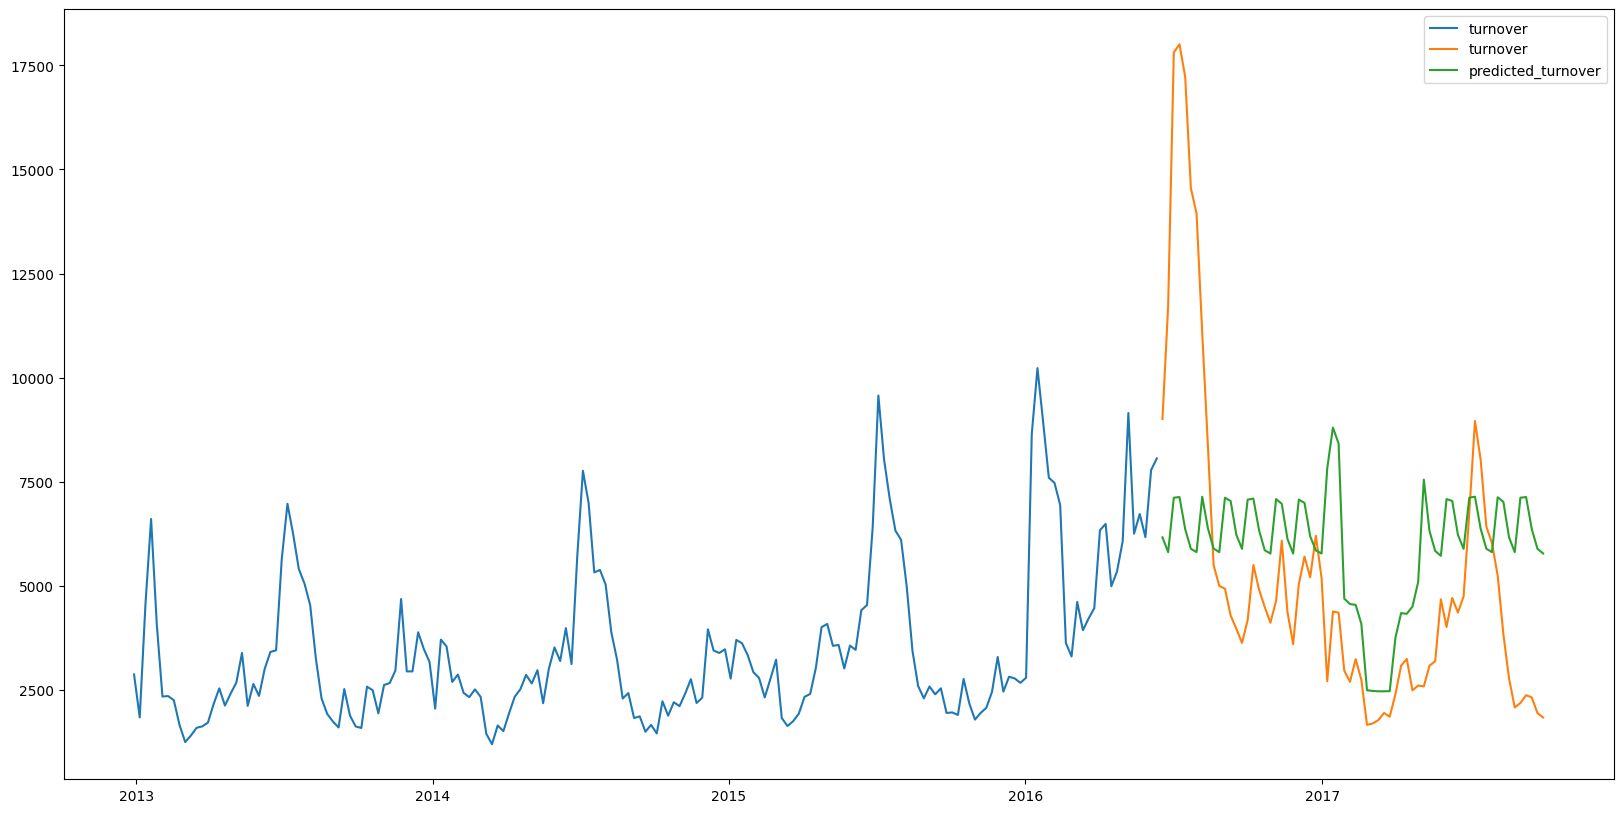

In [181]:
store_dep = random.choice(valid_data['store-dep'].unique())
df_store_dep = valid_data[valid_data['store-dep'] == store_dep]
df_store_dep_train = train_data[train_data['store-dep'] == store_dep]
plt.figure(figsize=(20,10))
plt.plot(df_store_dep_train['day_id'], df_store_dep_train['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['predicted_turnover'], label='predicted_turnover')
plt.legend()

This simple model is note very performant, sometimes it may provide a forecast that is kinda close to the average (or the trend) of the time series but it clearly fails at capturing more advanced pattern.  
It also suffers from a "cold start" problem because if a new product or store is introduced and is not in the training dataset, the forecast is even less accurate and tends to look like a flatline.
It is expected for this kind of simple approach that does not make very good use of the sequential nature of the data.  
Also, I'm trying to predict way more that 8 weeks of data, so I will adapt my training and valid set to better reflect this constraint

In [185]:
latest_date = df_train['day_id'].max()
eight_weeks = pd.Timedelta(weeks=8)
split_date = latest_date - eight_weeks

In [186]:
train_data = df_train[df_train['day_id'] < split_date]
valid_data = df_train[df_train['day_id'] >= split_date]

X_train = train_data[['but_num_business_unit','dpt_num_department', 'year', 'month', 'day', 'week_nb']]
X_valid = valid_data[['but_num_business_unit','dpt_num_department', 'year', 'month', 'day', 'week_nb']]
y_train = train_data[['turnover']]
y_valid = valid_data[['turnover']]

In [187]:
model = RandomForestRegressor(
    n_estimators=1000, 
    max_depth=10, 
    random_state=42,
    verbose=1
    )
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_valid)
mean_squared_error(y_valid, y_pred)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   38.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s


348544.67249778664

In [188]:
valid_data['predicted_turnover'] = y_pred

/var/folders/03/l545z9rn7g1fjdv8_3lflcbm0000gp/T/ipykernel_19688/2173448063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['predicted_turnover'] = y_pred


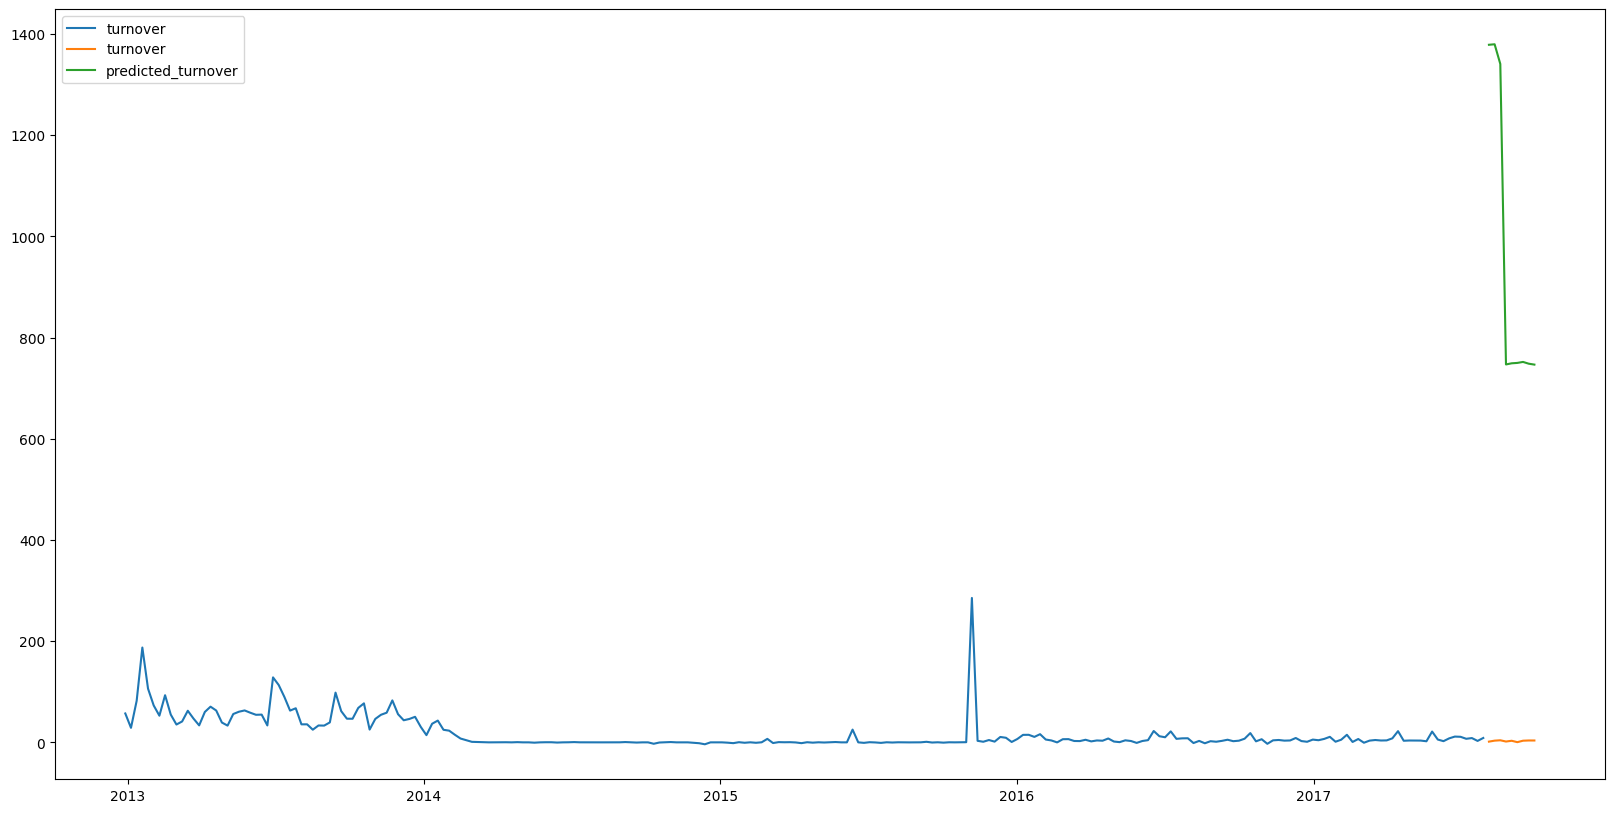

In [194]:
store_dep = random.choice(valid_data['store-dep'].unique())
df_store_dep = valid_data[valid_data['store-dep'] == store_dep]
df_store_dep_train = train_data[train_data['store-dep'] == store_dep]
plt.figure(figsize=(20,10))
plt.plot(df_store_dep_train['day_id'], df_store_dep_train['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['predicted_turnover'], label='predicted_turnover')
plt.legend()

The model is still pretty innacurate and tend to output even more "flat" prediction which could be expected for smaller forecasting horizon (horizon = 8)

# 2 model approach

Since I expect sales of similar items to have close trend and seasonal pattern, I will try to learn a prophet model for each department who will capture the global forecast for all my stores.  
Then I will use a tree-based model to allocate this forecast to all the different stores since I will be manipulating tabular data.

In [229]:
print(df_train.dpt_num_department.unique())
print(df_test.dpt_num_department.unique())

[117 127  73  88]
[ 73 117 127  88]


In [230]:
latest_date = df_train['day_id'].max()
split_date = latest_date - pd.Timedelta(weeks=8)

In [231]:
df_train_agg = df_train.groupby(['dpt_num_department', 'day_id'])['turnover'].sum().reset_index()
train_data = df_train_agg[df_train_agg['day_id'] < split_date]
valid_data = df_train_agg[df_train_agg['day_id'] >= split_date]

In [232]:
from prophet import Prophet

model_dict = {}
valid_dict = {}
for department in df_train_agg.dpt_num_department.unique():
    train_dpt = train_data[train_data['dpt_num_department'] == department]
    valid_dpt = valid_data[valid_data['dpt_num_department'] == department]  
    train_dpt = train_dpt[['day_id', 'turnover']]
    train_dpt.columns = ['ds', 'y']
    valid_dpt = valid_dpt[['day_id', 'turnover']]
    valid_dpt.columns = ['ds', 'y']
    model = Prophet()
    model.fit(train_dpt)
    model_dict[department] = model
    valid_dict[department] = valid_dpt

22:40:16 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing
22:40:16 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing
22:40:16 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing
22:40:16 - cmdstanpy - INFO - Chain [1] start processing
22:40:16 - cmdstanpy - INFO - Chain [1] done processing


In [233]:
m = model_dict[73]
future = m.make_future_dataframe(periods=8,freq='W')
forecast = m.predict(future)


/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Axes: xlabel='ds', ylabel='y'>

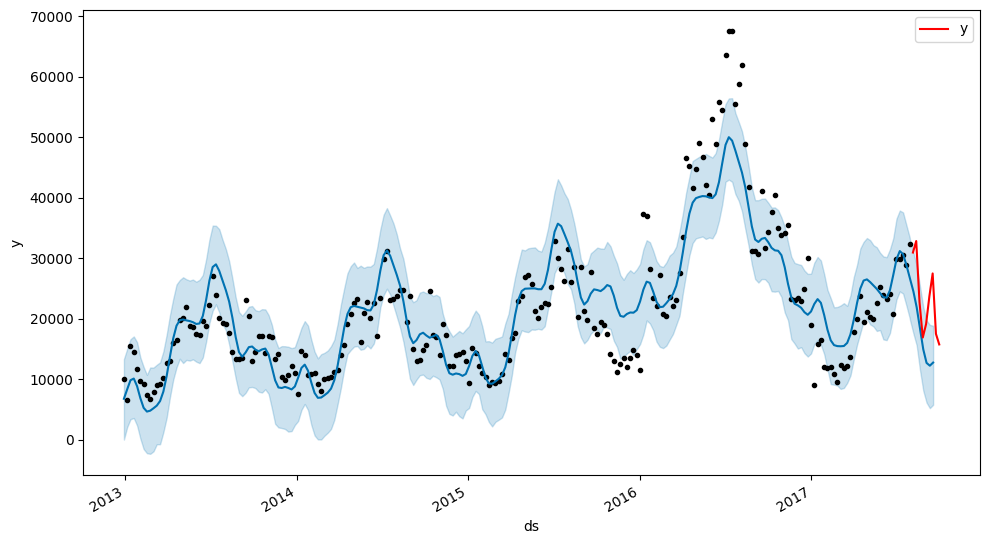

In [234]:
fig1 = m.plot(forecast)
y = valid_dict[73]

y.plot(x='ds', y='y', ax=fig1.gca(), color='red')

/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


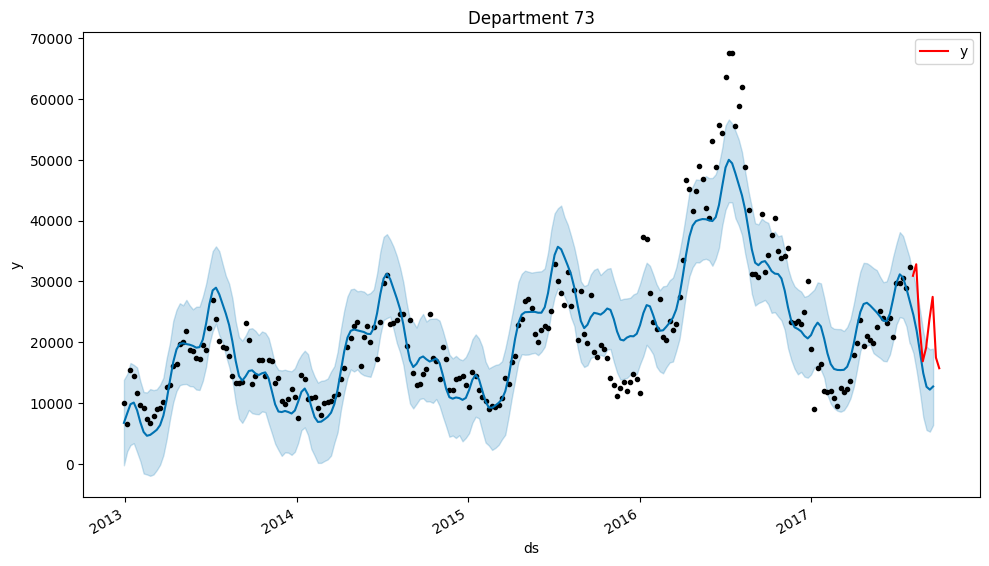

/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


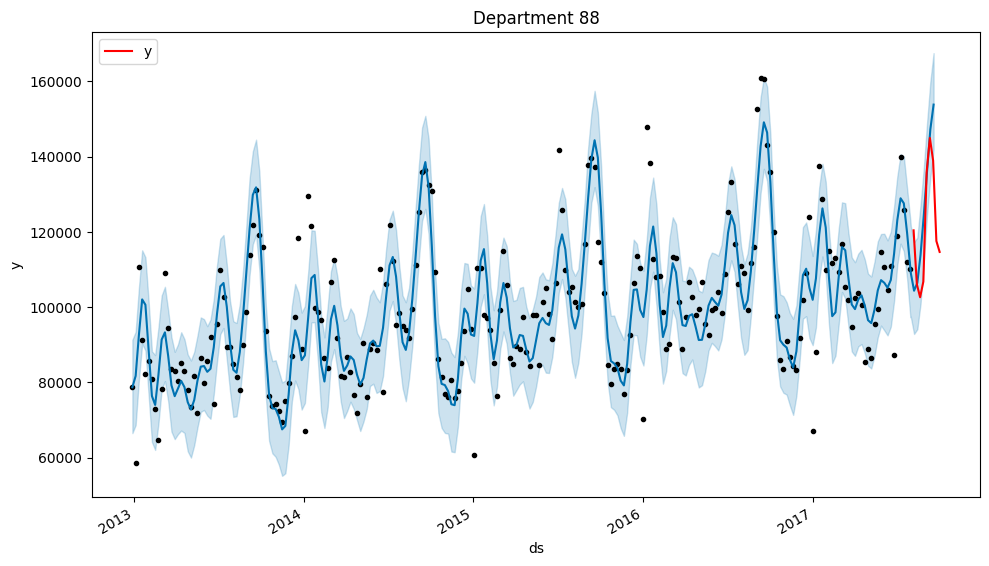

/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


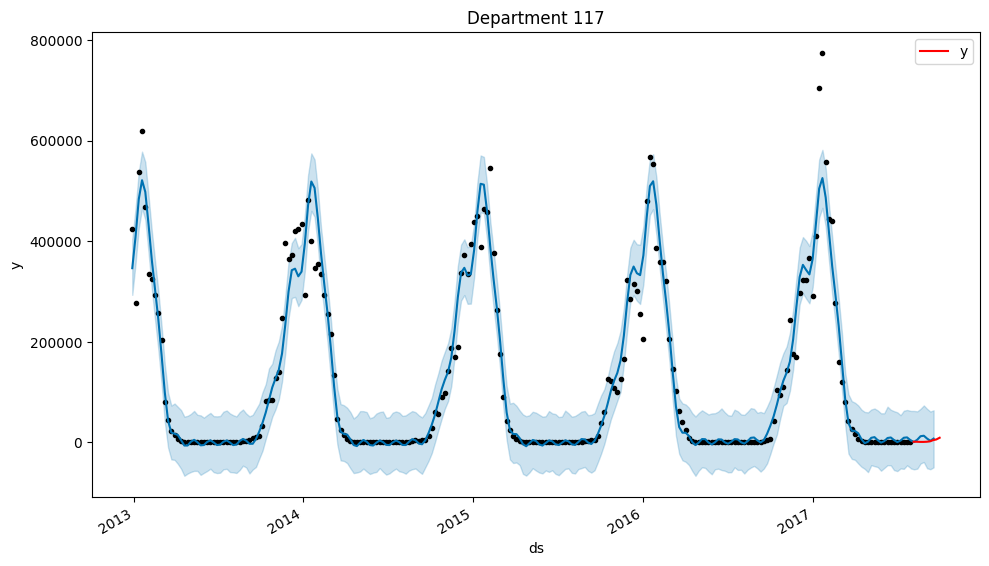

/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


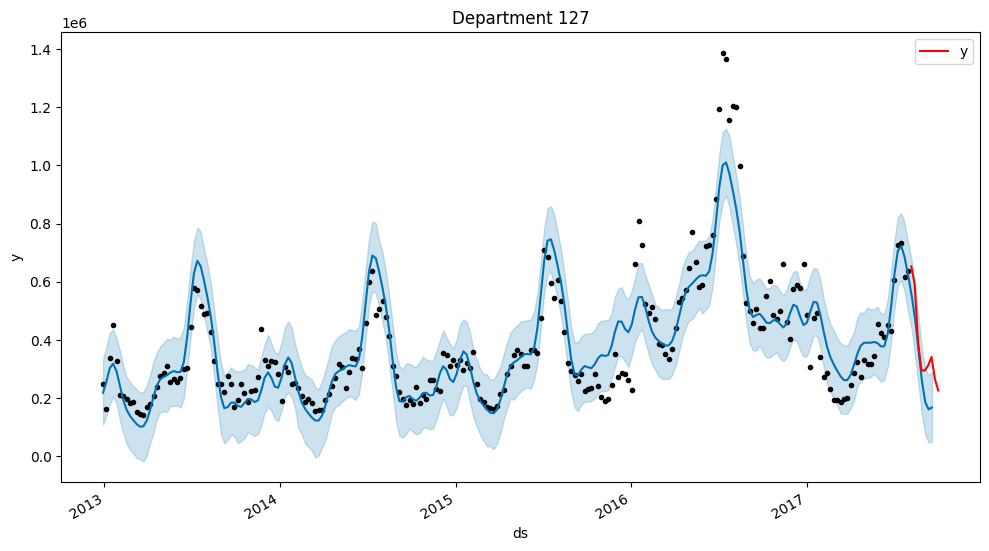

In [235]:
for department in df_train_agg.dpt_num_department.unique():
    m = model_dict[department]
    future = m.make_future_dataframe(periods=8,freq='W')
    forecast = m.predict(future)
    fig1 = m.plot(forecast)
    y = valid_dict[department]
    y.plot(x='ds', y='y', ax=fig1.gca(), color='red')
    plt.title(f'Department {department}')
    plt.show()

The global forecast seems to be quite accurate or at least not too far from what we could expect.   
Let's try to split them for each store.

In [278]:
final_train_ds = df_train.drop(columns=['store-dep', 'is_outlier', 'rolling_mean', 'rolling_std', 'is_outlier_rolling']).merge(df_train_agg.rename(columns={'turnover':'global_turnover'}), on=['dpt_num_department', 'day_id'], how='left')

In [291]:
final_train_ds['turnover_week-8'] = final_train_ds.groupby('dpt_num_department')['global_turnover'].shift(8, fill_value=0)
final_train_ds['turnover_week-9'] = final_train_ds.groupby('dpt_num_department')['global_turnover'].shift(9, fill_value=0)
final_train_ds['turnover_week-10'] = final_train_ds.groupby('dpt_num_department')['global_turnover'].shift(10, fill_value=0)


In [314]:
train_data = final_train_ds[final_train_ds['day_id'] < split_date]
valid_data = final_train_ds[final_train_ds['day_id'] >= split_date]

X_train = train_data[['but_num_business_unit','dpt_num_department', 'year', 'month', 'day', 'week_nb', 'global_turnover']]
X_valid = valid_data[['but_num_business_unit','dpt_num_department', 'year', 'month', 'day', 'week_nb', 'global_turnover']]
y_train = train_data[['turnover']]
y_valid = valid_data[['turnover']]

In [315]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, verbose=2, random_state=42)

model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_valid)
mean_squared_error(y_valid, y_pred)

      Iter       Train Loss   Remaining Time 
         1      792817.1605           56.56s
         2      717845.4433           53.23s
         3      653971.5202           56.55s
         4      600352.6532           56.45s
         5      555219.0690           56.92s
         6      517456.3384           56.68s
         7      487594.9048           55.99s
         8      461155.5082           56.82s
         9      439296.6669           58.71s
        10      421670.7894            1.14m
        11      405914.2006            1.13m
        12      392963.7230            1.11m
        13      381901.2667            1.12m
        14      372737.8859            1.11m
        15      365066.1762            1.08m
        16      358514.1179            1.08m
        17      352767.7521            1.06m
        18      348009.2449            1.05m
        19      344036.0583            1.04m
        20      339972.8624            1.03m
        21      335860.3262            1.03m
        2

76557.87323791256

In [316]:
valid_data['predicted_turnover'] = y_pred

/var/folders/03/l545z9rn7g1fjdv8_3lflcbm0000gp/T/ipykernel_19688/2173448063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['predicted_turnover'] = y_pred


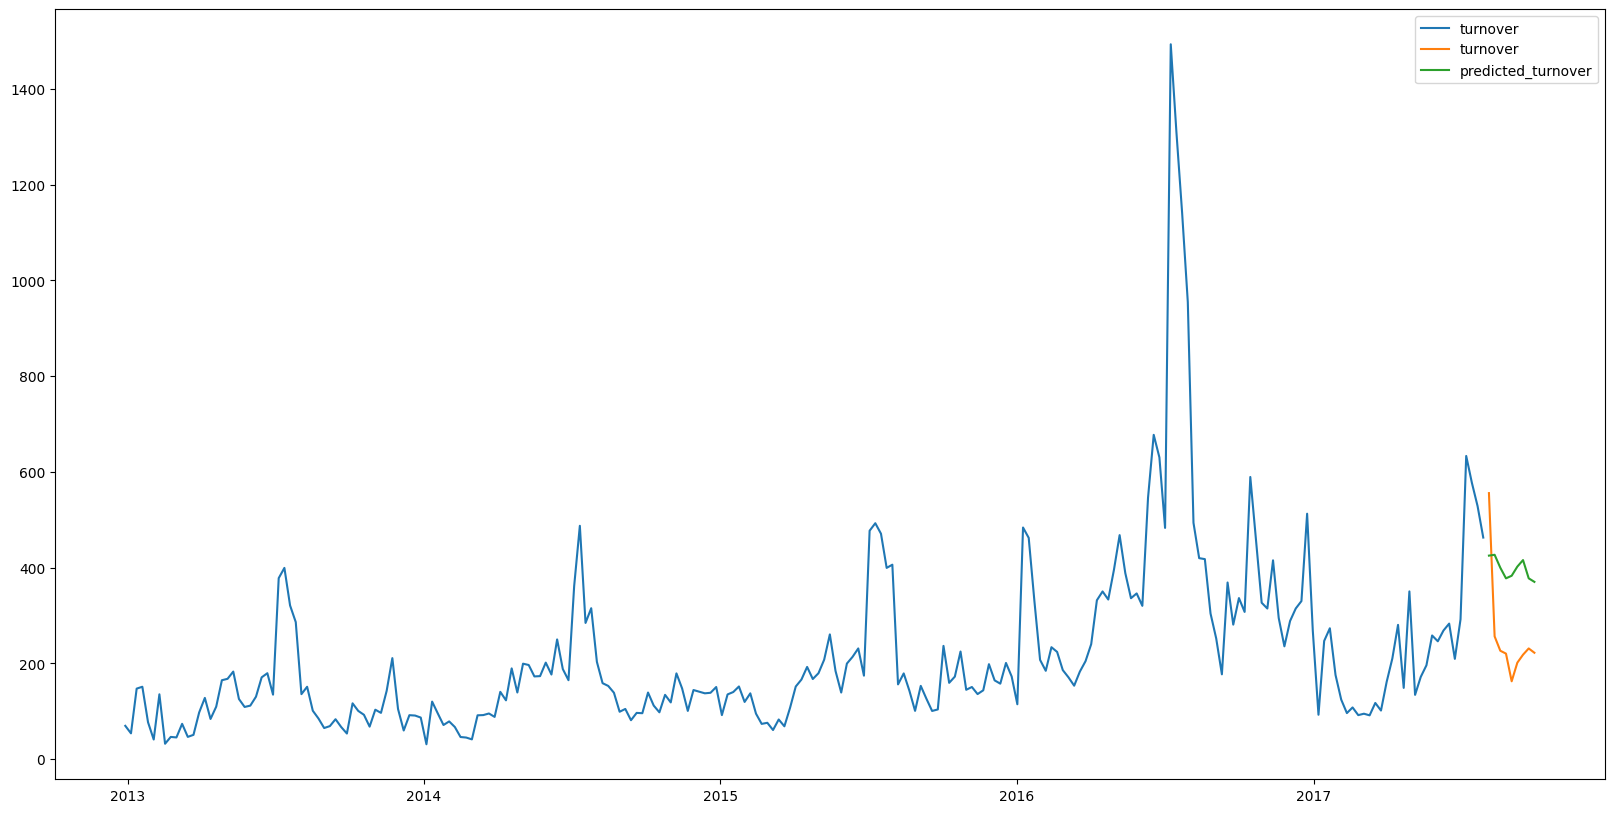

In [323]:
store = random.choice(valid_data['but_num_business_unit'].unique())
product = random.choice(valid_data['dpt_num_department'].unique())
df_store_dep = valid_data[(valid_data['but_num_business_unit'] == store) & (valid_data['dpt_num_department'] == product)]
df_store_dep_train = train_data[(train_data['but_num_business_unit'] == store) & (train_data['dpt_num_department'] == product)]
plt.figure(figsize=(20,10))
plt.plot(df_store_dep_train['day_id'], df_store_dep_train['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['predicted_turnover'], label='predicted_turnover')
plt.legend()

This 2 model approach is way better that the simpler solution but still sometimes fails by quite a big margin on specific BU - Department pairs by overshooting or undershooting a lot.  

I am a bit disapointed but that might be explanable by what the second model is trying to accomplish: basically, it is kinda learning what should be the share of the store turnover in the total turnover for a specific department. When coming up with this idea, I was expecting this share to not change a lot through time which is probably not true as new store are opened or closed during the time period.     
We can also expect changes with the rise of e-commerce which may disminish the sales for some store and increase it for some other that act as bigger warehouse.  
Considering a smaller time period, closer to recent events, may actually be beneficial.

# Prophet at the Store-Dep level

In [324]:
df_train

,day_id,but_num_business_unit,dpt_num_department,turnover,year,month,day,week_nb,store-dep,is_outlier,rolling_mean,rolling_std,is_outlier_rolling
277208,2012-12-29,1,117,972.944128,2012,12,29,52,1-117,False,NaN,NaN,False
276317,2013-01-05,1,117,693.710507,2013,1,5,1,1-117,False,NaN,NaN,False
275475,2013-01-12,1,117,1573.372954,2013,1,12,2,1-117,False,NaN,NaN,False
274456,2013-01-19,1,117,2257.608634,2013,1,19,3,1-117,False,NaN,NaN,False
272833,2013-01-26,1,117,1554.636857,2013,1,26,4,1-117,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5488,2017-09-02,99,88,465.496675,2017,9,2,35,99-88,False,505.393848,81.685244,False
5026,2017-09-09,99,88,598.059404,2017,9,9,36,99-88,False,NaN,NaN,False
2815,2017-09-16,99,88,537.166281,2017,9,16,37,99-88,False,NaN,NaN,False
1808,2017-09-23,99,88,433.077609,2017,9,23,38,99-88,False,NaN,NaN,False


In [325]:
df_train_agg = df_train.groupby(['store-dep', 'day_id'])['turnover'].sum().reset_index()
train_data = df_train_agg[df_train_agg['day_id'] < split_date]
valid_data = df_train_agg[df_train_agg['day_id'] >= split_date]

In [327]:
model_dict = {}
valid_dict = {}
for store_dep in df_train_agg['store-dep'].unique():
    try :
        train_dpt = train_data[train_data['store-dep'] == store_dep]
        valid_dpt = valid_data[valid_data['store-dep'] == store_dep]  
        train_dpt = train_dpt[['day_id', 'turnover']]
        train_dpt.columns = ['ds', 'y']
        valid_dpt = valid_dpt[['day_id', 'turnover']]
        valid_dpt.columns = ['ds', 'y']
        model = Prophet()
        model.fit(train_dpt)
        model_dict[store_dep] = model
        valid_dict[store_dep] = valid_dpt
    except Exception as e:
        print(f'{e} for {store_dep}')

23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing
23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing
23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing
23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing
23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing
23:50:13 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1]

Dataframe has less than 2 non-NaN rows. for 1881-117


23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing


Dataframe has less than 2 non-NaN rows. for 1882-88


23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] 

/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Axes: xlabel='ds', ylabel='y'>

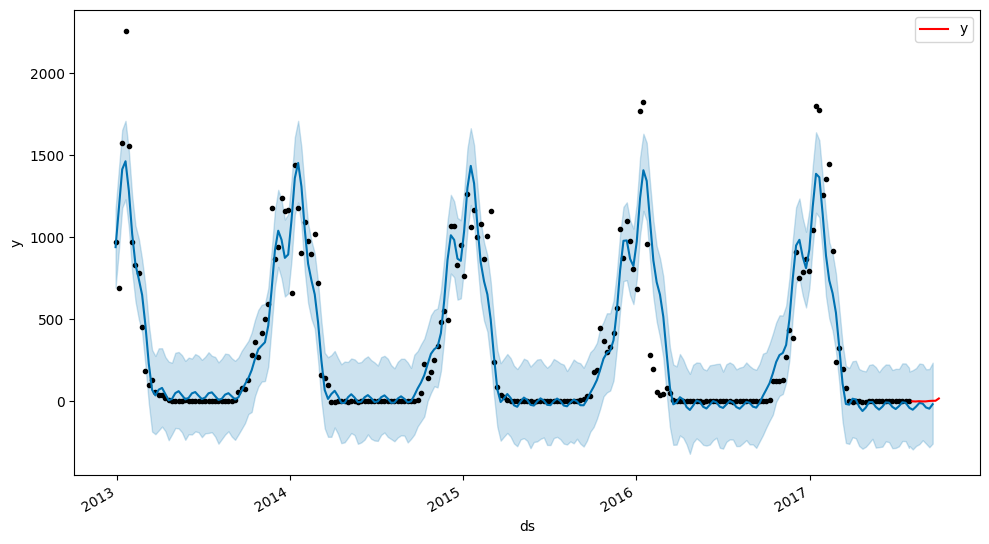

In [329]:
m = model_dict['1-117']
future = m.make_future_dataframe(periods=8,freq='W')
forecast = m.predict(future)
fig1 = m.plot(forecast)
y = valid_dict['1-117']
y.plot(x='ds', y='y', ax=fig1.gca(), color='red')

In [330]:
y

,ds,y
240,2017-08-05,0.921583
241,2017-08-12,-0.086756
242,2017-08-19,1.589890
243,2017-08-26,0.433780
244,2017-09-02,0.250099
245,2017-09-09,2.836569
246,2017-09-16,4.018738
247,2017-09-23,4.226570
248,2017-09-30,18.139296


In [332]:
from sklearn.metrics import mean_squared_error

global_mse = 0
for store_dep in model_dict:
    m = model_dict[store_dep]
    y = valid_dict[store_dep]
    forecast = m.predict(y)
    mse = mean_squared_error(y['y'], forecast['yhat'])
    global_mse += mse
global_mse /= len(model_dict)
global_mse



56343.5536527951

/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/baptistepugnaire/Documents/Projects/GitHub/retail-forecast/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Axes: xlabel='ds', ylabel='y'>

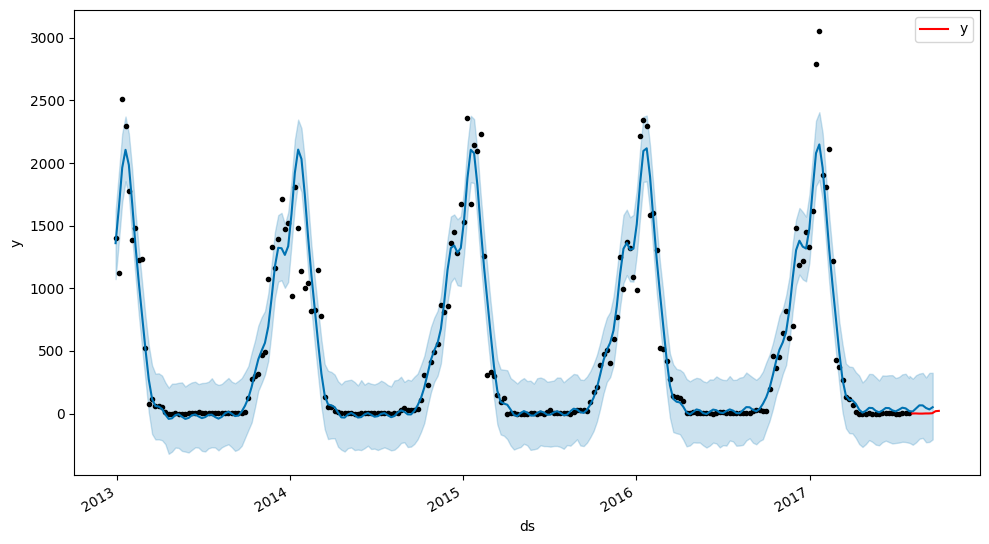

In [344]:
k = random.choice(list(model_dict.keys()))
m = model_dict[k]
future = m.make_future_dataframe(periods=8,freq='W')
forecast = m.predict(future)
fig1 = m.plot(forecast)
y = valid_dict[k]
y.plot(x='ds', y='y', ax=fig1.gca(), color='red')

This solution is not perfect as it implies storing a lot of different models but the size is still manageable and the performance seems satisfaying considering we did not perform any additionnal parameter tuning. Simply using the prophet algorithm as is.  

One issue remain, 2 store-dep pair could not be processed by this approach because it seems that they had too few values.

In [345]:
len(model_dict)

1268

In [346]:
len(df_train['store-dep'].unique())

1270

# b. Which metric would you use to evaluate your predictions and why?

To evaluate my predictions I think I would calculate some usual global metrics like RMSE or MAPE to have a general idea of the performance.  

But I think it would be interesting to also look at a way of penalizing a model that is extremely performant on a specific department (or specific store) compared but also very innacurate on an other department (or store). I would want my predictions to be generally good for everyone and everything rather than a situation with more variance (even if the global performance appears to be lower).
